# ITI110 Energy Consumption Prediction - Optimisation Attempt 3 (Mag)
### hourly dataset, loss: Poisson, input_size: 19, max_length: 85

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Hourly Dataset

In [4]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

user_folder = '/content/drive/My Drive/Data/ITI110/'

Mounted at /content/drive


In [155]:
# Load dataset after removing outlier meters and aggregating all meters by hour and day
df_hourly = pd.read_csv(user_folder+'2.2 merged_aggregated_hourly_without_block_id.csv')
df_hourly.head()

,date,month,hour,count_LCLid,count_block_id,sum_energy_by_hour,tstp,avg_energy_per_lclid,holiday,visibility,...,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,2011-11-23,11,9,2,2,1.130,2011-11-23 09:00:00,0.565000,0.0,4.39,...,4.84,2011-11-23 09:00:00,4.68,1027.29,3.42,1.78,rain,partly-cloudy-day,0.99,Partly Cloudy
1,2011-11-23,11,10,6,4,1.508,2011-11-23 10:00:00,0.251333,0.0,6.24,...,5.74,2011-11-23 10:00:00,5.46,1027.67,4.24,1.99,rain,partly-cloudy-day,0.98,Partly Cloudy
2,2011-11-23,11,11,7,5,2.123,2011-11-23 11:00:00,0.303286,0.0,10.20,...,7.67,2011-11-23 11:00:00,5.74,1027.56,5.94,2.66,rain,partly-cloudy-day,0.88,Partly Cloudy
3,2011-11-23,11,12,10,7,6.589,2011-11-23 12:00:00,0.658900,0.0,11.62,...,8.84,2011-11-23 12:00:00,6.52,1027.24,7.25,2.80,rain,partly-cloudy-day,0.85,Partly Cloudy
4,2011-11-23,11,13,13,9,6.263,2011-11-23 13:00:00,0.481769,0.0,12.68,...,9.87,2011-11-23 13:00:00,6.99,1027.35,8.29,3.12,rain,partly-cloudy-day,0.82,Mostly Cloudy


In [156]:
# Load dataset after removing outlier meters and aggregating all meters by hour and day
df_daily = pd.read_csv(user_folder+'2.3 merged_aggregated_daily_without_block_id.csv')
df_daily = df_daily[:-1]
df_daily.head()

,date,month,count_LCLid,count_block_id,sum_energy_by_day,avg_energy_per_lclid,holiday,temperatureMax,temperatureMaxTime,windBearing,...,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,day
0,2011-11-23,11,13,9,90.385000,6.952692,0.0,10.36,2011-11-23 14:00:00,229.0,...,2011-11-23 07:32:38,2011-11-23 14:00:00,2011-11-23 10:00:00,Foggy in the morning.,2011-11-23 22:00:00,2.18,2011-11-23 14:00:00,2011-11-23 22:00:00,0.94,2011-11-23
1,2011-11-24,11,25,15,213.412000,8.536480,0.0,12.93,2011-11-24 12:00:00,204.0,...,2011-11-24 07:34:14,2011-11-24 12:00:00,2011-11-24 10:00:00,Partly cloudy throughout the day.,2011-11-24 19:00:00,7.01,2011-11-24 12:00:00,2011-11-24 19:00:00,0.97,2011-11-24
2,2011-11-25,11,32,17,303.993000,9.499781,0.0,13.03,2011-11-25 05:00:00,243.0,...,2011-11-25 07:35:49,2011-11-25 12:00:00,2011-11-25 10:00:00,Partly cloudy throughout the day.,2011-11-26 01:00:00,4.84,2011-11-25 05:00:00,2011-11-26 05:00:00,0.01,2011-11-25
3,2011-11-26,11,41,20,420.976000,10.267707,0.0,12.96,2011-11-26 14:00:00,237.0,...,2011-11-26 07:37:22,2011-11-26 14:00:00,2011-11-26 10:00:00,Mostly cloudy throughout the day and breezy ov...,2011-11-26 23:00:00,4.69,2011-11-26 14:00:00,2011-11-26 23:00:00,0.05,2011-11-26
4,2011-11-27,11,41,20,444.883001,10.850805,0.0,13.54,2011-11-27 10:00:00,256.0,...,2011-11-27 07:38:54,2011-11-27 10:00:00,2011-11-27 10:00:00,Breezy in the morning and partly cloudy until ...,2011-11-28 05:00:00,2.94,2011-11-27 10:00:00,2011-11-28 05:00:00,0.08,2011-11-27


In [12]:
# Change 'tstp' to datetime format
df_hourly['datetime'] = pd.to_datetime(df_hourly["tstp"], format='%Y-%m-%d %H:%M:%S')
df_daily['date'] = pd.to_datetime(df_daily["date"], format='%Y-%m-%d')

In [157]:
# find energy range within day from hourly dataset
erg_max = pd.Series(df_hourly.groupby(by='date')['avg_energy_per_lclid'].max(), name = 'erg_max')
erg_min = pd.Series(df_hourly.groupby(by='date')['avg_energy_per_lclid'].min(), name = 'erg_min')

df_energy = pd.concat([erg_min, erg_max], axis = 1)
df_energy['erg_range']= df_energy['erg_max'] - df_energy['erg_min']
df_energy.reset_index()

,date,erg_min,erg_max,erg_range
0,2011-11-23,0.251333,0.861846,0.610513
1,2011-11-24,0.221692,0.678880,0.457188
2,2011-11-25,0.273640,0.662969,0.389329
3,2011-11-26,0.243406,0.722683,0.479277
4,2011-11-27,0.288585,0.699512,0.410927
...,...,...,...,...
824,2014-02-24,0.229509,0.740056,0.510547
825,2014-02-25,0.224047,0.738832,0.514785
826,2014-02-26,0.228710,0.721416,0.492706
827,2014-02-27,0.226965,0.722878,0.495913


In [158]:
# merge energy info with daily dataset
df_daily = df_daily.merge(df_energy, on='date', how='inner')

In [152]:
# find parameters to plot sine
from scipy import optimize
import math
from IPython.display import display, Math

def test_func(x, dist, amp, omega, phi):
    return dist + amp * np.cos(omega * x + phi)

test_func(830, 10.4, 5.6, 365, 38)

params, params_covariance = optimize.curve_fit(test_func, x_data, df_daily['avg_energy_per_lclid'], p0=[1, 1, 2, 1])

print('Fitted parameters:')
display(Math('a_0={:.2f}, a_1={:.2f}, \\omega={:.2f}, \\phi={:.2f}'.format(*params)))
print('Original parameters:')
display(Math('a_0={:.2f}, a_1={:.2f}, \\omega={:.2f}, \\phi={:.2f}'.format(*[10.0, 5.0, 3.0, 2.0])))

Fitted parameters:


<IPython.core.display.Math object>

Original parameters:


<IPython.core.display.Math object>

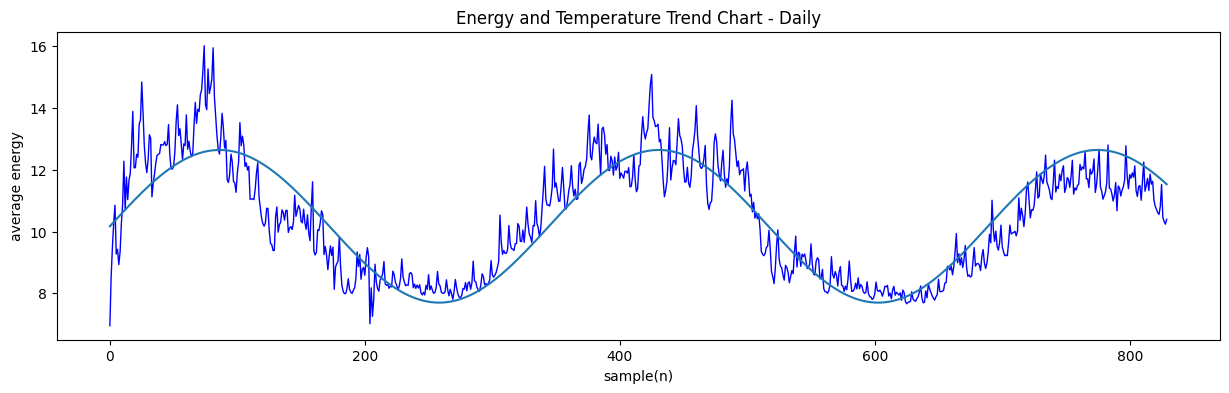

In [160]:
plt.figure(figsize=(15,4))
ax = sns.lineplot(data = df_daily, x = df_daily.index, y = 'avg_energy_per_lclid', color = 'b', linewidth= 1)
ax.set_title("Energy and Temperature Trend Chart - Daily")

x = np.arange(830)
y = (np.sin(2 * np.pi * 2.41* x / 830))*2.47 +10.17
plt.plot(x, y)
plt.xlabel('sample(n)')
plt.ylabel('average energy')

plt.show()

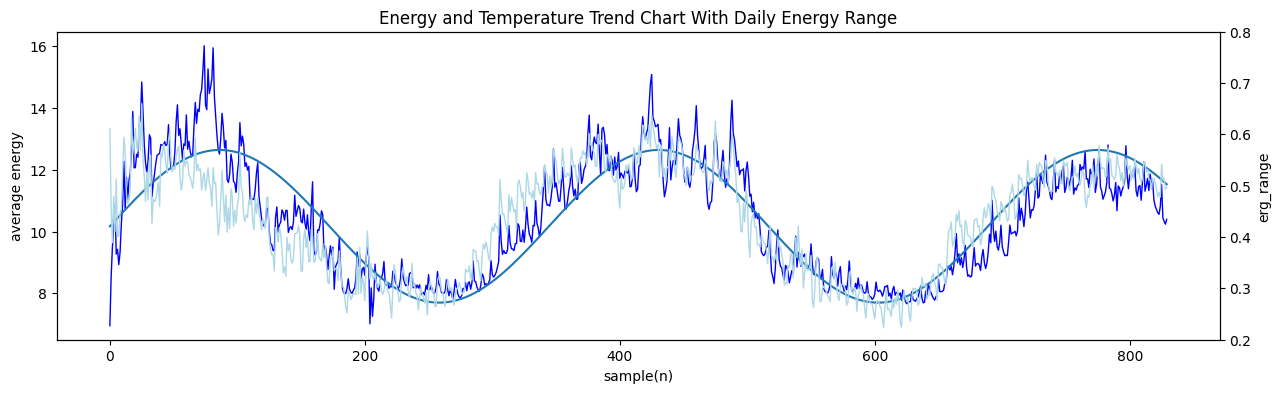

In [164]:
plt.figure(figsize=(15,4))
ax = sns.lineplot(data = df_daily, x = df_daily.index, y = 'avg_energy_per_lclid', color = 'b', linewidth= 1)
ax.set_title("Energy and Temperature Trend Chart With Daily Energy Range")

x = np.arange(830)
y = (np.sin(2 * np.pi * 2.41* x / 830))*2.47 +10.17
plt.plot(x, y)
plt.xlabel('sample(n)')
plt.ylabel('average energy')

ax2 = plt.twinx()
ax2 = sns.lineplot(data = df_daily, x = df_daily.index, y = 'erg_range', color = 'lightblue', linewidth= 1)
ax2.set_ylim(0.2, 0.8)
plt.show()

### The behaviour of the daily average curve follows sine wave with more flucutations at the top. Relationship of within-day energy range could not help explain why energy prediction during winter months are lower than actual.